In [1]:
# ----------------------------------------------------------------
# IoT Netprofiler
# Licensed under The MIT License [see LICENSE for details]
# Written by Luca Maiano - https://www.linkedin.com/in/lucamaiano/
# ----------------------------------------------------------------

# Attack Detection

In this notebook we apply *learning algorithms* with the aim of detect attacks in an IoT network as accurately as possible. Particularly, we will focus on **supervised** and **unsupervised** algorithms. With this analysis, we want to compare the effectiveness of the following algorithms:
1. K-Nearest Neighbor (KNN)
2. Random Forests Classifier
3. Support Vector Machines (SVM)
5. Deep Neural Network Classifier 
6. K-Means

All mentioned algorithms have been extensively used by *state of the art* solutions in order to solve **anomaly-detection** problems [2].

## Metrics Identification

Using the same approach of Yavuz et al. [1], in order to deal with an imbalanced dataset we use AUC-ROC together with the following metrics:
1. 
$
\begin{align}
Precision = \frac{TP}{TP+FP}
\end{align}
$

2. 
$
\begin{align}
Recall = \frac{TP}{TP+FN}
\end{align}
$

3. 
$
\begin{align}
F1 = 2\frac{precision * recall}{precision+recall}
\end{align}
$
4. AUC-ROC. 

If the AUC-ROC is bigger than 0.5, it means that the model is better than random guessing. We *validate* all the algorithms above with a 5-cross validation during the training phase, finally we *test* the results on a test set.




In [45]:
import csv
import pandas as pd
import numpy as np
import sys, os
import random

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from lib.utils import trace_processing
from lib.visualization import data_visualization
from lib.analysis import trace_statistics
from lib.analysis import trace_classification


Let us start importing 2 sets of experiments:
1. *9 nodes* examples containing grids and random topologies;
2. *16 nodes* examples containing grids and random topologies.

In [46]:
exp_9_nodes = trace_processing.import_trace('data/experiments/cooja3-9nodes/traces/', 'traces.csv')
exp_16_nodes = trace_processing.import_trace('data/experiments/cooja3-16nodes/traces/', 'traces.csv')

experiments = exp_9_nodes + exp_16_nodes

# Experiment 1: Attacked vs Normal Behaviour

Now we import *features* and *normalize* the data to speedup the learning process. For this experiment, we consider just two classes:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Attacked** (1), i.e. an attack has been performed (Black Hole or Gray Hole).

In [47]:
data = None
n_classes = 2

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=random.choice([12, 24, 48, 100, 200]))    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=random.choice([12, 24, 48, 100, 200]))])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])
norm_data.head(5)

,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7408:8:808:,16nodes/grid_1gh30-7_2019-02-19_22:35_,0.141038,0.111111,0.814583,0.376878,0.25,0.527131,0.837492,0.151899,0.1250,1
1,aaaa::212:7409:9:909:,16nodes/grid_normal_2019-02-26_11:10_,0.050139,0.045455,0.557288,0.053006,0.50,0.526365,0.518081,0.006329,0.0000,0
2,aaaa::212:7407:7:707:,16nodes/grid_normal_2019-02-26_10:53_,0.040404,0.035354,0.575424,0.145752,0.25,0.448587,0.552412,0.094937,0.1250,0
3,aaaa::212:7406:6:606:,9nodes/grid9_1bh-5_2019-02-13_15:31_,0.041967,0.040404,0.478893,0.248533,0.25,0.321562,0.555288,0.012658,0.1875,1
4,aaaa::212:7405:5:505:,9nodes/rnd2_normal_2019-02-14_16:07_,0.039440,0.050505,0.210701,0.009541,0.25,0.229564,0.164359,0.000000,0.0000,0


Now we can split the dataset in *training and testing set* of size 80% and 20% respectively.

In [48]:
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

X.head()

,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers
0,0.141038,0.111111,0.814583,0.376878,0.25,0.527131,0.837492,0.151899,0.1250
1,0.050139,0.045455,0.557288,0.053006,0.50,0.526365,0.518081,0.006329,0.0000
2,0.040404,0.035354,0.575424,0.145752,0.25,0.448587,0.552412,0.094937,0.1250
3,0.041967,0.040404,0.478893,0.248533,0.25,0.321562,0.555288,0.012658,0.1875
4,0.039440,0.050505,0.210701,0.009541,0.25,0.229564,0.164359,0.000000,0.0000


## Feature Selection

Starting from the results that we obtained during the data exploration phase, we can now start to train and compare the learning algorithms. The results will be compared with different sets of features. Features will be iteratively selected removing the most relevant and less relevant feature. Most significant feature is dropped to avoid *overfitting*, less relevant feature is dropped to avoid *underfitting*.

The experiment will be repeated iteratively following this way:
1. select a set of feature;
2. run learning algorithms;
3. measure performances.

At the end the best set of features will be selected. We start selecting the entire set of features.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [49]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.7989057239057239
AUC on validation set 2/5: 0.7989898989898991
AUC on validation set 3/5: 0.8099718647663854
AUC on validation set 4/5: 0.7848346478483464
AUC on validation set 5/5: 0.8218406762927312
Mean AUC 0.803 (Std +/- 0.012)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.803406,0.79781,0.794549,0.79601,0.794549


2. Now we evaluate **RandomForest Classifier**.

In [50]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.8247474747474748
AUC on validation set 2/5: 0.8117003367003366
AUC on validation set 3/5: 0.8259766615931
AUC on validation set 4/5: 0.7848577095152438
AUC on validation set 5/5: 0.8075481303221029
Mean AUC 0.808 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.829721,0.829888,0.815789,0.820818,0.815789


3. Prediction of **Support Vector Machines (SVM)**.

In [51]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.7893097643097643
AUC on validation set 2/5: 0.7701178451178451
AUC on validation set 3/5: 0.7431622157649554
AUC on validation set 4/5: 0.7419630090862968
AUC on validation set 5/5: 0.7769961742564482
Mean AUC 0.764 (Std +/- 0.019)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.752322,0.755062,0.726316,0.731972,0.726316


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 83.34% (Std +/- 1.59%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.823529,0.847324,0.795865,0.80643,0.795865


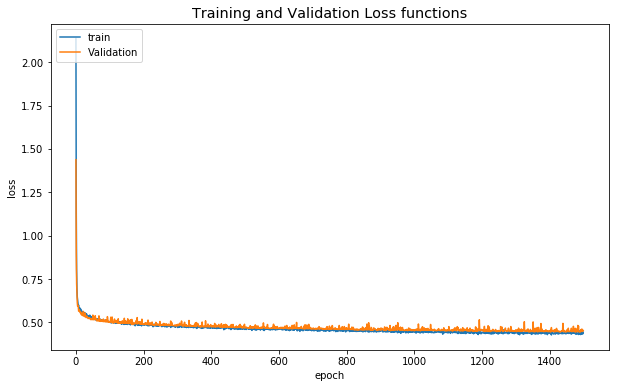

In [52]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '2classes_ATCK_NORM_RANDOMpckts')
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [53]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns))
X_pca.head()

,0,1,2,3,4,5,6,7,8
0,0.415529,0.181561,0.518578,0.043916,0.046315,-0.012873,0.025505,0.070125,-0.006882
1,0.257652,-0.121415,0.016869,0.107460,-0.029324,-0.009979,-0.005277,-0.006267,-0.001863
2,0.112699,-0.000900,0.241983,0.083086,0.031366,0.092726,-0.005672,0.029270,0.003775
3,0.018882,0.051063,0.246154,-0.077059,-0.066117,0.087928,-0.010465,0.027560,0.000231
4,-0.349227,-0.114330,-0.124786,0.026503,0.003612,0.005206,0.034523,-0.001250,-0.004067


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.375891,0.3834,0.382168,0.375668,0.382168


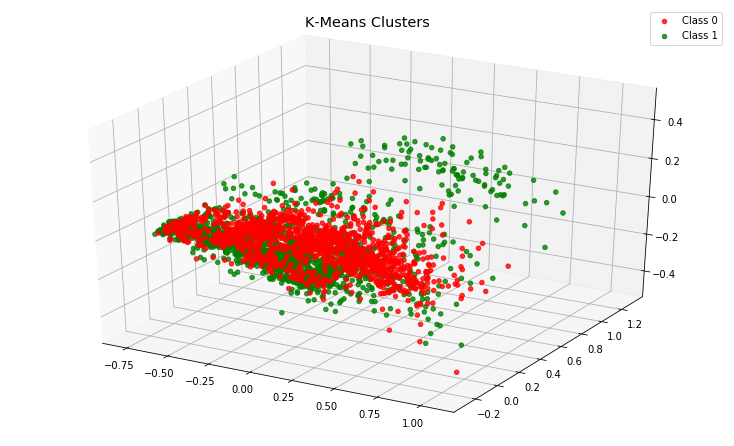

In [54]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=2)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K2_RANDOMpckts', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [55]:
trace_classification.write_results([knn_results, rfc_results, svm_results, nn_results, kmeans_results], list(X.columns.values), 'ATCK_NORM_RANDOMpckts', 2)

,model,n_classes,accuracy,precision,recall,f1-score,auc roc,features
0,knn,2,0.803406,0.797810,0.794549,0.796010,0.794549,"hop, loss, max, mean, min, outliers, pckt_coun..."
1,random forest,2,0.829721,0.829888,0.815789,0.820818,0.815789,"hop, loss, max, mean, min, outliers, pckt_coun..."
2,svm,2,0.752322,0.755062,0.726316,0.731972,0.726316,"hop, loss, max, mean, min, outliers, pckt_coun..."
3,neural network,2,0.823529,0.847324,0.795865,0.806430,0.795865,"hop, loss, max, mean, min, outliers, pckt_coun..."
4,kmeans,2,0.375891,0.383400,0.382168,0.375668,0.382168,"hop, loss, max, mean, min, outliers, pckt_coun..."


Based on the table above, we see that the **neural network** outperform all the other models. **KNN** also achieve really good results follwed by *random forsests*.

# Experiment 2: Normal Behaviour vs Grey Hole vs Black Hole Attack

For this second scenario, we want to detect which attack has been performed (if any). Each node will be labeled as follows:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Grey Hole** (1);
3. **Black Hole** (2).

In [56]:
data = None
n_classes = 3

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=random.choice([12, 24, 48, 100, 200]))    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=random.choice([12, 24, 48, 100, 200]))])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])

# Normalize data
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

norm_data.head()

,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7402:2:202:,9nodes/rnd2_1bh-8_2019-02-15_17:28_,0.028760,0.045918,0.042085,0.018072,0.00,0.057194,0.047191,0.005076,0.000000,2
1,aaaa::212:7405:5:505:,9nodes/rnd_1gh-2_2019-02-16_08:37_,0.187046,0.234694,0.229704,0.028080,0.25,0.241663,0.310048,0.000000,0.000000,1
2,aaaa::212:7404:4:404:,9nodes/grid9_normal_2019-02-13_22:23_,0.091801,0.107143,0.300519,0.153249,0.25,0.224490,0.371766,0.005076,0.142857,0
3,aaaa::212:7406:6:606:,9nodes/rnd2_1bh-3_2019-02-14_17:02_,0.033272,0.051020,0.067406,0.042085,0.00,0.053557,0.066689,0.000000,0.000000,2
4,aaaa::212:740a:a:a0a:,16nodes/grid_1gh70-9_2019-02-19_23:34_,0.150062,0.132653,0.637944,0.140308,0.75,0.466246,0.613591,0.101523,0.000000,1


## Feature Selection

We repeat the experiment following the same identical approach as before. Thus we choose a set of features, and we iterate removing the most important and less importan one until we obtain the best results.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [57]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.7653766619579588
AUC on validation set 2/5: 0.7508084901268907
AUC on validation set 3/5: 0.764153548600479
AUC on validation set 4/5: 0.7511265901169324
AUC on validation set 5/5: 0.7663841051444068
Mean AUC 0.760 (Std +/- 0.007)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.712963,0.69808,0.708799,0.70169,0.777039


2. Now we evaluate **RandomForest Classifier**.

In [58]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.7372690850879907
AUC on validation set 2/5: 0.7788528146173967
AUC on validation set 3/5: 0.7604515530391668
AUC on validation set 4/5: 0.7466293291187469
AUC on validation set 5/5: 0.7685027462127336
Mean AUC 0.769 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.75,0.759638,0.727007,0.740593,0.791564


3. Prediction of **Support Vector Machines (SVM)**.

In [59]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.6311867103973497
AUC on validation set 2/5: 0.6292469088729352
AUC on validation set 3/5: 0.6317781099451457
AUC on validation set 4/5: 0.6083491148470461
AUC on validation set 5/5: 0.6385315302802743
Mean AUC 0.628 (Std +/- 0.010)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.616667,0.686075,0.503812,0.514424,0.628717


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 45.60% (Std +/- 0.07%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.505556,0.168519,0.333333,0.223862,0.5


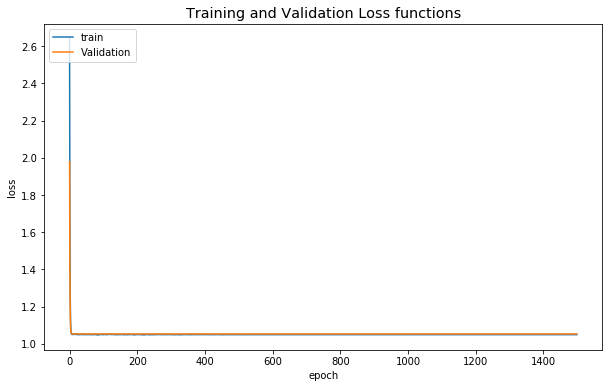

In [60]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '3classes_BH_GH_NORM_RANDOMpckts')
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [61]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns))
X_pca.head()

,0,1,2,3,4,5,6,7,8
0,-0.693175,-0.073371,-0.092295,0.008385,0.035267,0.016815,0.014583,-0.003902,0.011114
1,-0.229942,0.065206,-0.143571,-0.096601,-0.028287,-0.073904,-0.018820,0.017112,-0.008229
2,-0.175872,0.057090,0.032703,0.077449,-0.018038,-0.004161,-0.007093,-0.015120,-0.000491
3,-0.672758,-0.058660,-0.068411,0.010196,0.031385,0.002408,0.022945,-0.016998,0.007606
4,0.500268,-0.096769,-0.010878,-0.053214,0.048967,-0.084829,-0.010775,-0.076873,-0.008840


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.439585,0.433131,0.38186,0.376426,0.538705


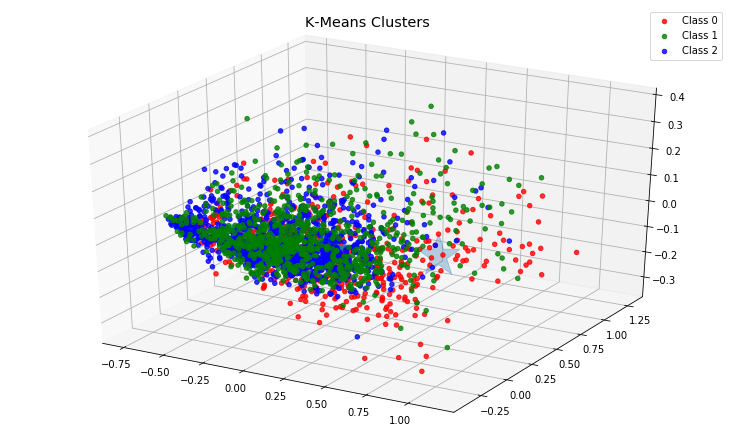

In [62]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=3)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K3_RANDOMpckts', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [63]:
trace_classification.write_results([knn_results, rfc_results, svm_results, nn_results, kmeans_results], list(X.columns.values), 'BH_GH_NORM_RANDOMpckts', 3)

,model,n_classes,accuracy,precision,recall,f1-score,auc roc,features
0,knn,3,0.712963,0.698080,0.708799,0.701690,0.777039,"hop, loss, max, mean, min, outliers, pckt_coun..."
1,random forest,3,0.750000,0.759638,0.727007,0.740593,0.791564,"hop, loss, max, mean, min, outliers, pckt_coun..."
2,svm,3,0.616667,0.686075,0.503812,0.514424,0.628717,"hop, loss, max, mean, min, outliers, pckt_coun..."
3,neural network,3,0.505556,0.168519,0.333333,0.223862,0.500000,"hop, loss, max, mean, min, outliers, pckt_coun..."
4,kmeans,3,0.439585,0.433131,0.381860,0.376426,0.538705,"hop, loss, max, mean, min, outliers, pckt_coun..."


In this case, the **neural network** still performs good, folloed by **svm**.

# References

1. *Deep Learning for Detection of Routing Attacks in the Internet of Things*, International Journal of Computational Intelligence Systems (2018), by Furkan Yusuf Yavuz, Devrim Ünal and Ensar Gul
2. *Machine Learning in IoT Security:Current Solutions and Future Challenges*, arXiv:1904.05735v1 (Mar 2019), by Fatima Hussain, Rasheed Hussain, Syed Ali Hassan, and Ekram Hossain.
3. *Almost Everything You Need to Know About Time Series*, https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578, by Marco Peixeiro
4. *How to Check if Time Series Data is Stationary with Python*, https://machinelearningmastery.com/time-series-data-stationary-python/, by Jason Brownlee
5. *K-Means Clustering in Python*, https://mubaris.com/posts/kmeans-clustering/, by Mubaris NK
6. *AUC ROC Curve Scoring Function for Multi-class Classification*, https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659, by Eric Plog